In [16]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import scipy
import mne
import os
import pandas as pd
import numpy as np
import mne
import scipy

class NoValidTroughException(Exception):
    pass

class Waveform_analyzer:
    
    def __init__(self, sample_rate=1000, line_noise=60, bp_low_cutoff=5, bp_high_cutoff=90):
        self.sample_rate = sample_rate
        self.line_noise = line_noise
        self.filter = mne.filter.create_filter(None, sample_rate, l_freq=bp_low_cutoff, h_freq=bp_high_cutoff, 
                                fir_design='firwin', l_trans_bandwidth=5, 
                                h_trans_bandwidth=5, filter_length='1000ms')
    
    def get_peaks_around(self, trough_ind, arr_ind_peaks, filtered_dat):

        # find all peaks to the right (then left) side, then take the closest one to the trough
        ind_greater = np.where(arr_ind_peaks>trough_ind)[0]
        if ind_greater.shape[0] == 0:
            raise NoValidTroughException("No valid trough")
        val_ind_greater = arr_ind_peaks[ind_greater]
        peak_right_idx = arr_ind_peaks[ind_greater[np.argsort(val_ind_greater)[0]]]

        ind_smaller = np.where(arr_ind_peaks<trough_ind)[0]
        if ind_smaller.shape[0] == 0:
            raise NoValidTroughException("No valid trough")

        val_ind_smaller = arr_ind_peaks[ind_smaller]
        peak_left_idx = arr_ind_peaks[ind_smaller[np.argsort(val_ind_smaller)[-1]]]

        return peak_left_idx, peak_right_idx, filtered_dat[peak_left_idx], filtered_dat[peak_right_idx]

    def analyze_waveform(self, raw_dat, peak_dist=1, trough_dist=50, prominence_lim=0.5, label=False, y_contra=None, y_ipsi=None, \
                        plot_=False):
        
        # first notch filter data 
        raw_dat_z = scipy.stats.zscore(raw_dat)
        dat_notch_filtered = mne.filter.notch_filter(x=raw_dat_z, Fs=self.sample_rate, trans_bandwidth=7,
            freqs=np.arange(self.line_noise, 4*self.line_noise, self.line_noise),
            fir_design='firwin', verbose=False, notch_widths=1,filter_length=raw_dat.shape[0]-1)

        filtered_dat = scipy.signal.convolve(dat_notch_filtered, self.filter, mode='same')

        peaks = scipy.signal.find_peaks(filtered_dat, distance=peak_dist)[0]
        troughs = scipy.signal.find_peaks(-filtered_dat, distance=trough_dist)[0]
        
        if plot_ is True:
            plt.figure(figsize=(15,5))
            plt.plot(peaks, filtered_dat[peaks], "xr"); 
            plt.plot(troughs, filtered_dat[troughs], "ob"); 
            plt.plot(filtered_dat, color='black'); plt.legend(['peaks', 'trough'])
            #plt.show()
            
        df  = pd.DataFrame()
        sharp_wave = {}
        for trough_idx in troughs:
            try:
                peak_idx_left, peak_idx_right, peak_left, peak_right = self.get_peaks_around(trough_idx, 
                                                                                        peaks, filtered_dat)
            except NoValidTroughException as e:
                # in this case there is no adjacent two peaks around this trough
                print(str(e))
                continue

            # interval 
            if df.shape[0]>0:
                interval_ = (trough_idx - sharp_wave["trough_idx"]) * (1000/self.sample_rate)
            else:
                # set first interval to zero 
                interval_ = 0

            # sharpness
            if (trough_idx - int(5*(1000/self.sample_rate)) < 0) or \
                (trough_idx + int(5*(1000/self.sample_rate)) > filtered_dat.shape[0]): 
                continue
            # convert 5 ms to sample rate 
            sharpness = (filtered_dat[trough_idx-int(5*(1000/self.sample_rate))] + 
                         filtered_dat[trough_idx+int(5*(1000/self.sample_rate))]) / 2

            # rise_steepness, first der. from trough to peak 
            # here  + 1 due to python syntax, s.t. the last element is included
            rise_steepness = np.max(np.diff(filtered_dat[peak_idx_left : trough_idx+1]))

            # decay_steepness
            decay_steepness = np.max(np.diff(filtered_dat[trough_idx : peak_idx_right+1]))
            
            # prominence 
            prominence = np.abs((peak_right + peak_left) / 2 - filtered_dat[trough_idx])
            # criterium that states a certain prominence threshold
            if prominence < prominence_lim: # data is z-scored! 
                continue
            sharp_wave  = {
                "peak_left" : peak_left, 
                "peak_right" : peak_right,
                "peak_idx_left" : peak_idx_left,
                "peak_idx_right" : peak_idx_right,
                "trough" : filtered_dat[trough_idx], # mV
                "trough_idx" : trough_idx,
                "width" : peak_idx_right - peak_idx_left, # ms 
                "prominence": prominence, # mV
                "interval" : interval_, # ms
                "decay_time": (peak_idx_left - trough_idx) *(1000/self.sample_rate),
                "rise_time" : (peak_idx_right - trough_idx) *(1000/self.sample_rate),
                "sharpness" : sharpness,
                "rise_steepness" : rise_steepness, 
                "decay_steepness" : decay_steepness,
                "slope_ratio" : rise_steepness - decay_steepness, 
                "label" : False, 
                "MOV_TYPE" : None, 
                "y_contra" : None,
                "y_ipsi" : None
            }
            
            if label is True: 
                sharp_wave["label"] = True
                    # movement
                if y_ipsi[trough_idx] > 0:
                    MOV_ = "IPS"
                elif y_contra[trough_idx] > 0:
                    MOV_ = "CON"
                else:
                    MOV_ = "NO_MOV"
                sharp_wave["MOV_TYPE"] = MOV_
                sharp_wave["y_contra"] = y_contra[trough_idx] 
                sharp_wave["y_ipsi"] = y_ipsi[trough_idx]
            df = df.append(sharp_wave, ignore_index=True)
        return df 

In [2]:
# examplary try: read one run file and add the resp. features

In [3]:
raw = mne.io.read_raw_brainvision('C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\sub-000\\ses-right\\ieeg\\sub-000_ses-right_task-force_run-0_ieeg.vhdr')

Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...


In [17]:
waveform_analyzer = Waveform_analyzer(sample_rate=1000, line_noise=60)

No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-pass filter from 5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 92.50 Hz)
- Filter length: 1001 samples (1.001 sec)



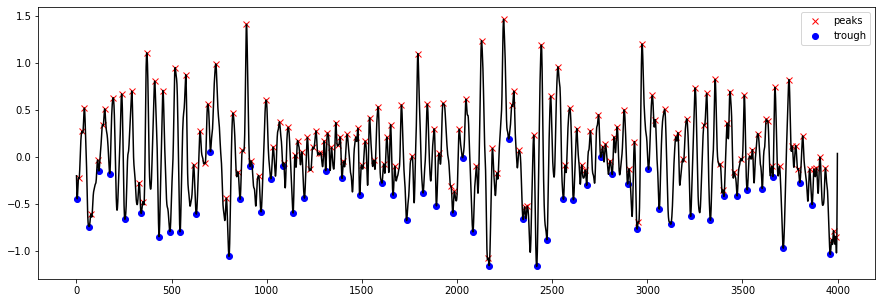

No valid trough


In [5]:
df = waveform_analyzer.analyze_waveform(raw.get_data()[5,15000:19000], peak_dist=1, trough_dist=50, 
                        label=True, y_contra=raw.get_data()[9,:], y_ipsi=raw.get_data()[8,:], plot_=True)

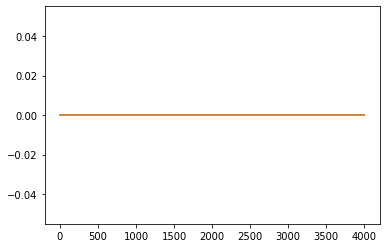

In [10]:
plt.plot(raw.get_data()[-1,15000:19000])
plt.plot(raw.get_data()[-2,15000:19000])

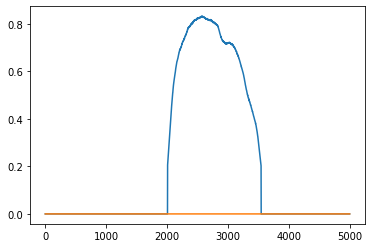

In [11]:
plt.plot(raw.get_data()[-1,40000:45000])
plt.plot(raw.get_data()[-2,40000:45000])

No valid trough
No valid trough


Text(0.5, 1.0, 'Mov Segment')

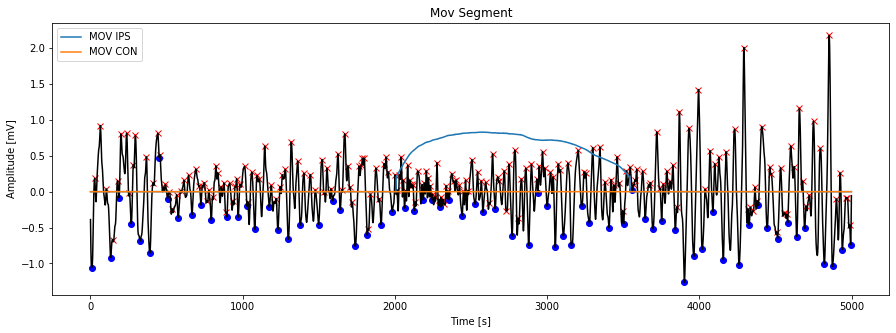

In [19]:
df = waveform_analyzer.analyze_waveform(raw.get_data()[5,40000:45000], peak_dist=1, trough_dist=50, 
                        label=True, y_contra=raw.get_data()[9,:], y_ipsi=raw.get_data()[8,:], plot_=True)
plt.plot(raw.get_data()[-1,40000:45000], label='MOV IPS')
plt.plot(raw.get_data()[-2,40000:45000], label='MOV CON')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')
plt.title("Mov Segment")

### rerun analysis for whole channel 

In [296]:
waveform_analyzer = Waveform_analyzer(sample_rate=1000, line_noise=60)

No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-pass filter from 5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 92.50 Hz)
- Filter length: 1001 samples (1.001 sec)



In [297]:
raw.get_data().shape

(10, 130001)

In [298]:
raw.ch_names

['ECOG_RIGHT_0',
 'ECOG_RIGHT_1',
 'ECOG_RIGHT_2',
 'ECOG_RIGHT_3',
 'ECOG_RIGHT_4',
 'ECOG_RIGHT_5',
 'MOV_RIGHT',
 'MOV_LEFT',
 'MOV_RIGHT_CLEAN',
 'MOV_LEFT_CLEAN']

In [299]:
df = waveform_analyzer.analyze_waveform(raw.get_data()[5,:], peak_dist=1, trough_dist=5, 
                        label=True, y_contra=raw.get_data()[9,:], y_ipsi=raw.get_data()[8,:])

In [300]:
def plot_mov_sep_hist(metric, label):
    sn.distplot(df[df.MOV_TYPE.str.contains("NO_MOV")][metric], label='None', color='black')
    sn.distplot(df[df.MOV_TYPE.str.contains("CON")][metric], label='CON', color='red')
    sn.distplot(df[df.MOV_TYPE.str.contains("IPS")][metric], label='IPS', color='blue')
    plt.title(metric)
    plt.xlabel(metric + " [" + label+"]")
    plt.legend()

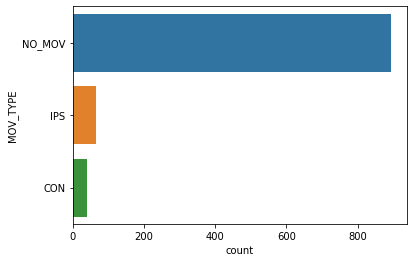

In [301]:
# well, the data is non balanced, but we expect to have less sharp waves during movement 
sn.countplot(y="MOV_TYPE", data = df)

In [292]:
df["MOV_TYPE"].unique()

array(['NO_MOV', 'CON', 'IPS'], dtype=object)

In [260]:
df.melt(id_vars="MOV_TYPE")

,MOV_TYPE,variable,value
0,NO_MOV,decay_steepness,0.008298
1,NO_MOV,decay_steepness,0.072975
2,NO_MOV,decay_steepness,0.039166
3,NO_MOV,decay_steepness,0.083922
4,NO_MOV,decay_steepness,0.194119
...,...,...,...
87835,NO_MOV,y_ipsi,0.000000
87836,NO_MOV,y_ipsi,0.000000
87837,NO_MOV,y_ipsi,0.000000
87838,NO_MOV,y_ipsi,0.000000


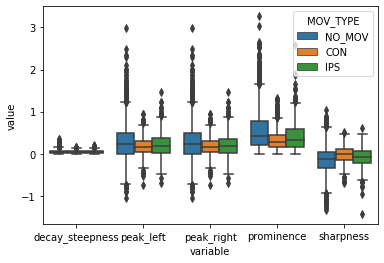

In [264]:
sn.boxplot(x="variable", y="value", hue="MOV_TYPE", 
           data=df[["decay_steepness", "peak_left", "peak_right", "prominence", "sharpness", "MOV_TYPE"]].melt(id_vars="MOV_TYPE"))

In [267]:
df.keys()

Index(['MOV_TYPE', 'decay_steepness', 'decay_time', 'interval', 'label',
       'peak_idx_left', 'peak_idx_right', 'peak_left', 'peak_right',
       'prominence', 'rise_steepness', 'rise_time', 'sharpness', 'slope_ratio',
       'trough', 'trough_idx', 'width', 'y_contra', 'y_ipsi'],
      dtype='object')

### with prominence limitation

In [311]:
raw = mne.io.read_raw_brainvision('C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\sub-000\\ses-right\\ieeg\\sub-000_ses-right_task-force_run-1_ieeg.vhdr')

Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...


0
No valid trough


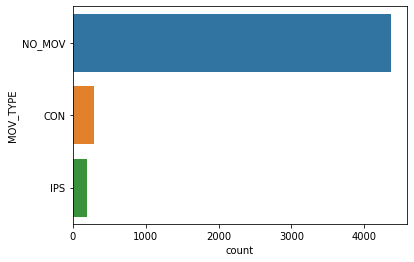

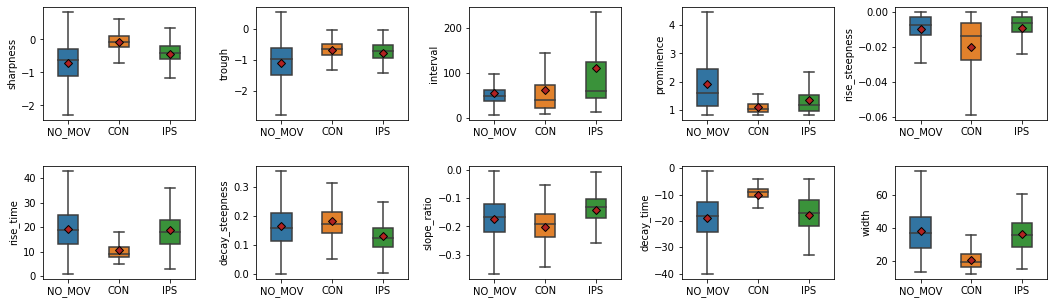

1


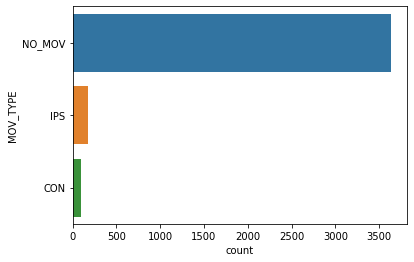

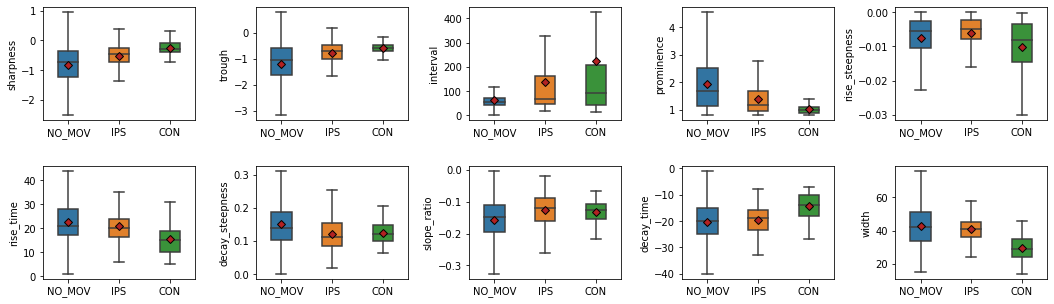

2
No valid trough


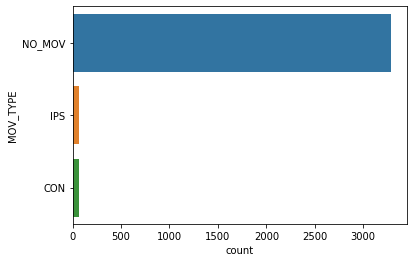

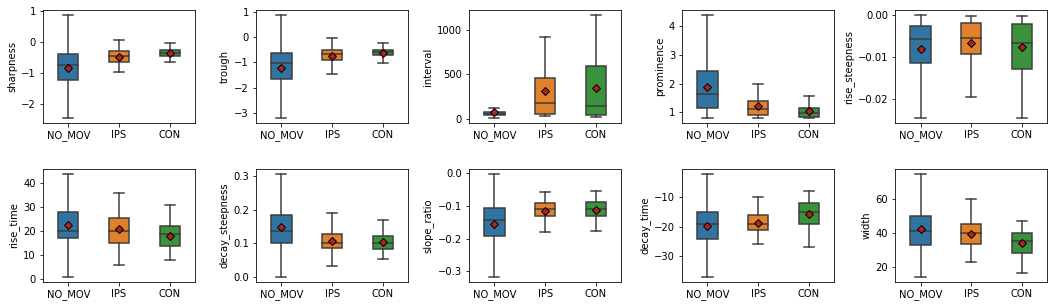

3
No valid trough


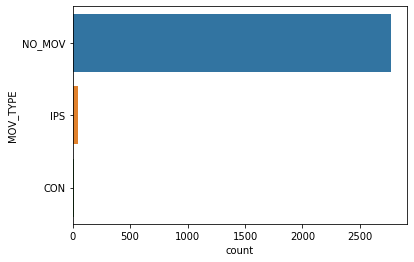

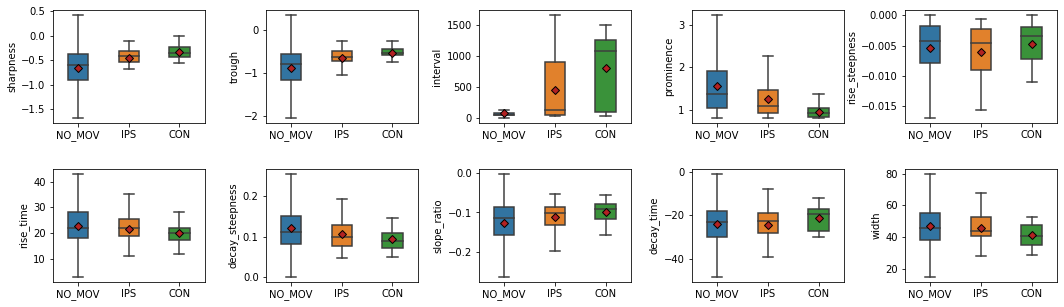

4
No valid trough


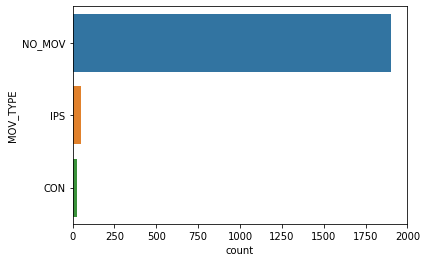

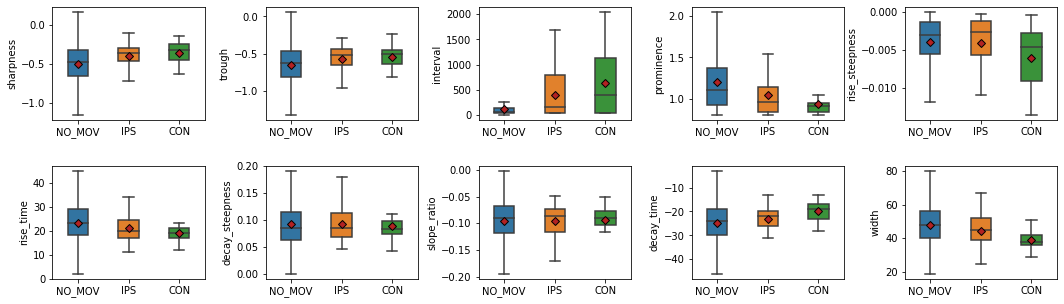

5
No valid trough
No valid trough


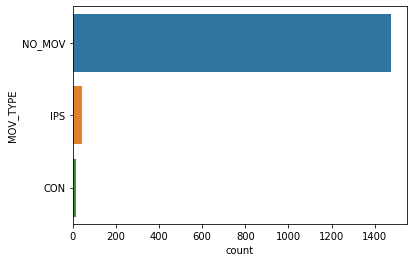

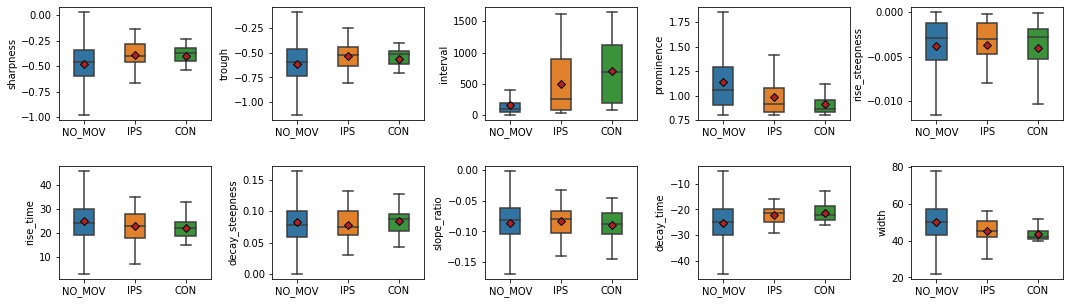

In [312]:
for ch_idx in range(6):
    print(ch_idx)
    df = waveform_analyzer.analyze_waveform(raw.get_data()[ch_idx,:], peak_dist=1, trough_dist=5, 
                            label=True, y_contra=raw.get_data()[9,:], y_ipsi=raw.get_data()[8,:])
    sn.countplot(y="MOV_TYPE", data = df)
    plt.show()


    fig = plt.figure(figsize=(18,5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    meanpointprops = dict(marker='D', markeredgecolor='black',
                          markerfacecolor='firebrick')

    for i, measure in enumerate(["sharpness", "trough", "interval", "prominence", "rise_steepness", "rise_time", \
              "decay_steepness", "slope_ratio", "decay_time", "width"]):
        ax = fig.add_subplot(2, 5, i+1)
        sn.boxplot(x="MOV_TYPE", y=measure, data=df, ax=ax, showmeans=True, width=0.4, showfliers=False, 
                  meanprops=meanpointprops)
        plt.xlabel('')
    plt.show()

### without prominence limitation

No valid trough


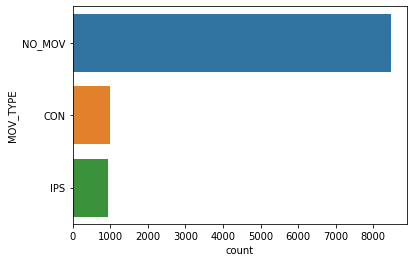

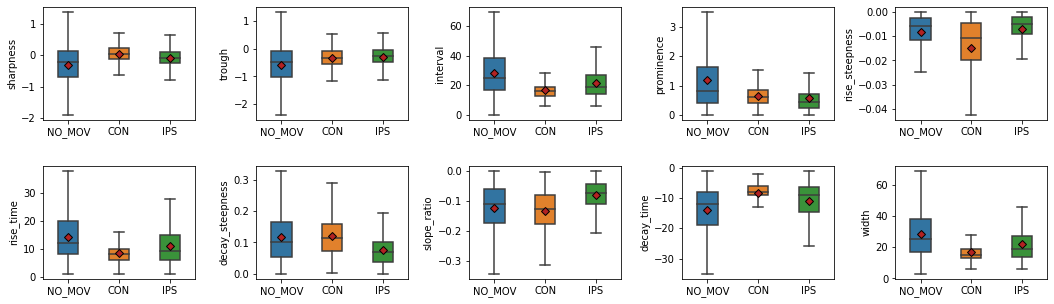

In [317]:
df = waveform_analyzer.analyze_waveform(raw.get_data()[0,:], peak_dist=1, trough_dist=5, 
                            label=True, y_contra=raw.get_data()[9,:], y_ipsi=raw.get_data()[8,:], prominence_lim=0)
sn.countplot(y="MOV_TYPE", data = df)
plt.show()


fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')

for i, measure in enumerate(["sharpness", "trough", "interval", "prominence", "rise_steepness", "rise_time", \
          "decay_steepness", "slope_ratio", "decay_time", "width"]):
    ax = fig.add_subplot(2, 5, i+1)
    sn.boxplot(x="MOV_TYPE", y=measure, data=df, ax=ax, showmeans=True, width=0.4, showfliers=False, 
              meanprops=meanpointprops)
    plt.xlabel('')
plt.show()

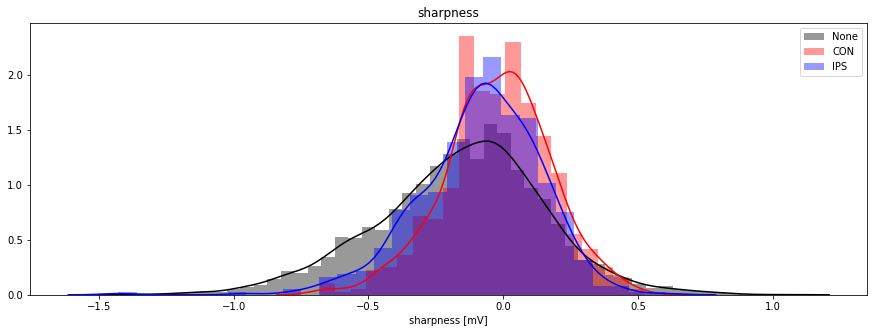

In [188]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("sharpness", "mV")

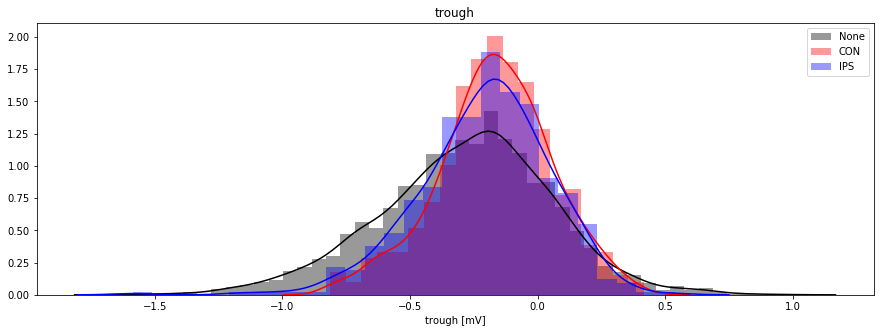

In [189]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("trough", "mV")

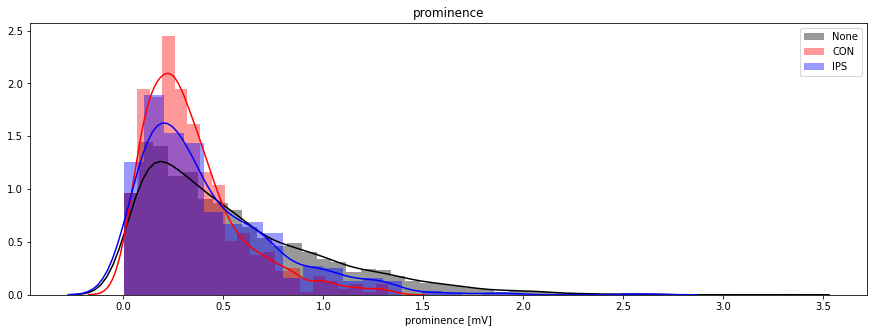

In [190]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("prominence", "mV")

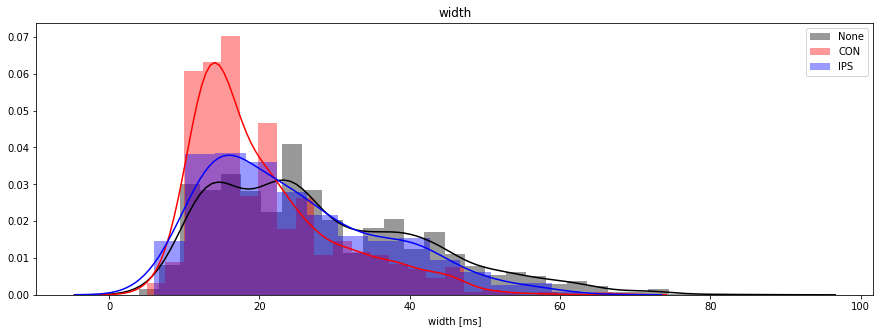

In [191]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("width", "ms")

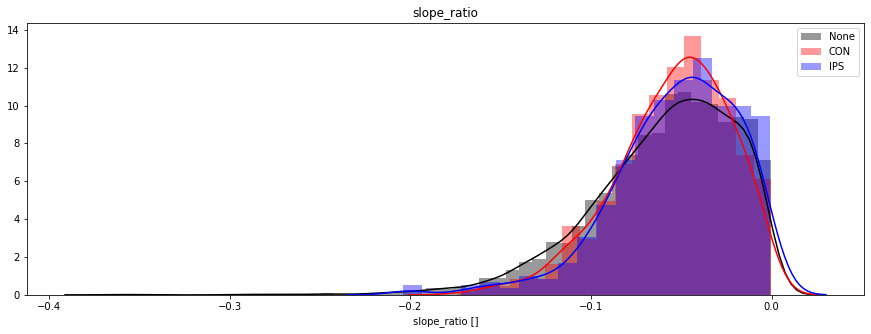

In [192]:
plt.figure(figsize=(15,5))
plot_mov_sep_hist("slope_ratio", "")

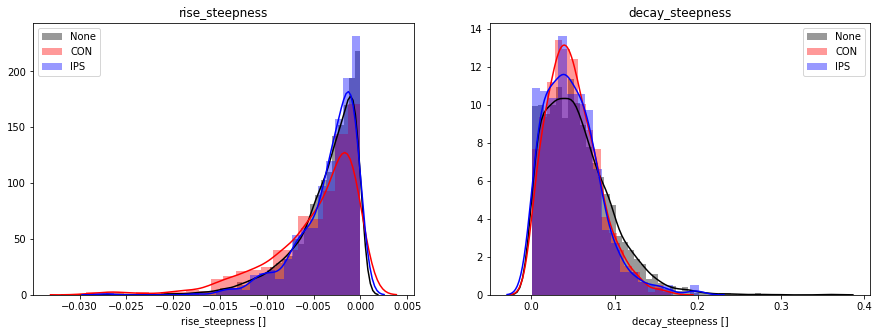

In [193]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_mov_sep_hist("rise_steepness", "")
plt.subplot(122)
plot_mov_sep_hist("decay_steepness", "")

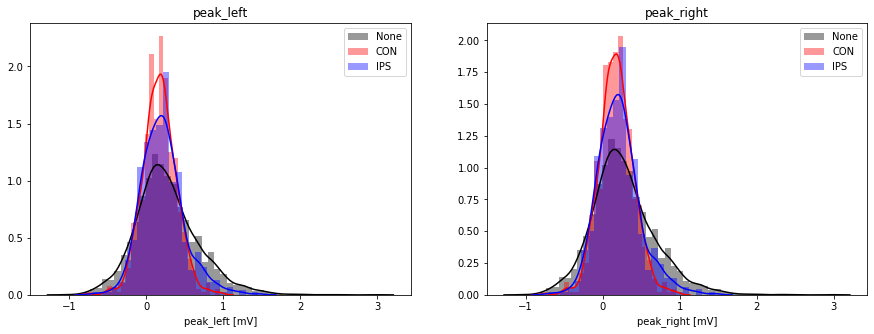

In [194]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_mov_sep_hist("peak_left", "mV")
plt.subplot(122)
plot_mov_sep_hist("peak_right", "mV")

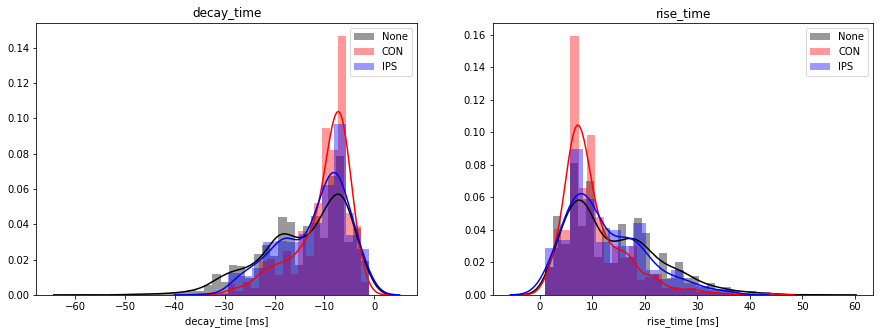

In [195]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_mov_sep_hist("decay_time", "ms")
plt.subplot(122)
plot_mov_sep_hist("rise_time", "ms")

In [206]:
df

,MOV_TYPE,decay_steepness,decay_time,interval,label,peak_idx_left,peak_idx_right,peak_left,peak_right,prominence,rise_steepness,rise_time,sharpness,slope_ratio,trough,trough_idx,width,y_contra,y_ipsi
0,NONE,0.008298,-20.0,0.0,1.0,3.0,26.0,0.606123,-0.270638,0.458105,-0.001907,3.0,-0.216582,-0.010205,-0.290363,23.0,23.0,0.0,0.0
1,NONE,0.072975,-7.0,10.0,1.0,26.0,48.0,-0.270638,0.349840,0.386776,-0.000954,15.0,-0.219541,-0.073929,-0.347175,33.0,22.0,0.0,0.0
2,NONE,0.039166,-12.0,27.0,1.0,48.0,67.0,0.349840,0.201022,0.262969,-0.002372,7.0,0.156892,-0.041538,0.012462,60.0,19.0,0.0,0.0
3,NONE,0.083922,-13.0,20.0,1.0,67.0,92.0,0.201022,0.093884,0.648968,-0.003771,12.0,-0.256199,-0.087692,-0.501515,80.0,25.0,0.0,0.0
4,NONE,0.194119,-8.0,20.0,1.0,92.0,114.0,0.093884,1.469652,0.826506,-0.003035,14.0,0.149616,-0.197153,-0.044738,100.0,22.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4875,NONE,0.032074,-20.0,50.0,1.0,129831.0,129858.0,2.340945,-0.814317,1.725163,-0.003026,7.0,-0.695762,-0.035100,-0.961849,129851.0,27.0,0.0,0.0
4876,NONE,0.079175,-10.0,17.0,1.0,129858.0,129905.0,-0.814317,0.215810,0.790832,-0.003762,37.0,-0.914252,-0.082937,-1.090085,129868.0,47.0,0.0,0.0
4877,NONE,0.006145,-7.0,44.0,1.0,129905.0,129916.0,0.215810,0.203983,0.025177,-0.000099,4.0,0.207211,-0.006244,0.184720,129912.0,11.0,0.0,0.0
4878,NONE,0.115093,-15.0,19.0,1.0,129916.0,129959.0,0.203983,1.604573,1.110323,-0.000264,28.0,-0.089527,-0.115357,-0.206045,129931.0,43.0,0.0,0.0


TypeError: 'NoneType' object is not iterable

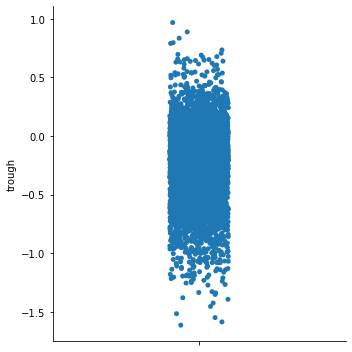

In [205]:
sn.catplot(y="trough", hue="MOV_TYPE", data = df)

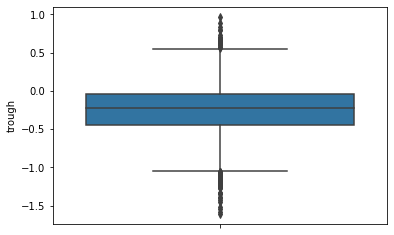

In [203]:
sn.boxplot(y="trough", hue="MOV_TYPE", data = df)

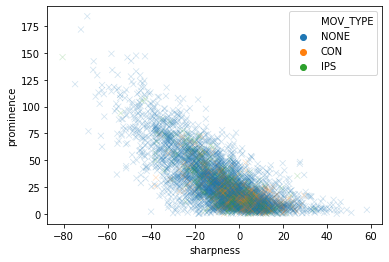

In [117]:
sn.scatterplot(x = "sharpness", y="prominence", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

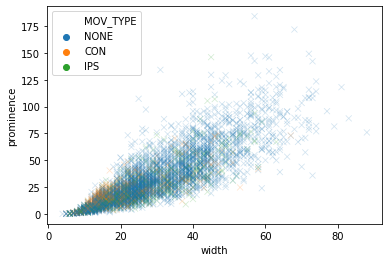

In [119]:
sn.scatterplot(x = "width", y="prominence", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

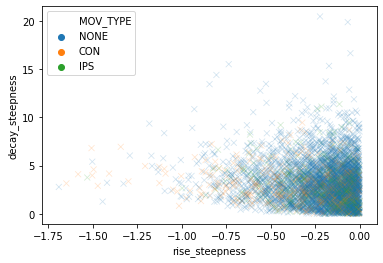

In [121]:
sn.scatterplot(x = "rise_steepness", y="decay_steepness", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

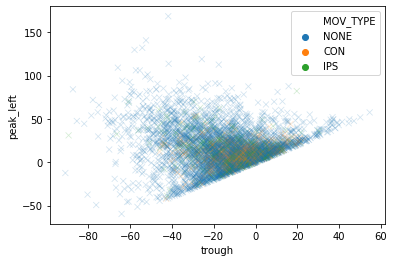

In [126]:
sn.scatterplot(x = "trough", y="peak_left", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

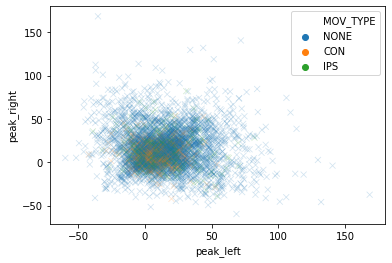

In [127]:
sn.scatterplot(x = "peak_left", y="peak_right", hue="MOV_TYPE", data = df, alpha=0.2, marker='x')

This analysis shows that it seems hard to separate movement from no movement. 
There are some important implementation remarks: 
1. During real time analysis the idea is to have snippets of 1s length (the upper code allows for that). 
2. How should the distribution be treated in this case? More than one sharp wave are usually detected... Calculate Mean everytime of every feature?
3. How to continue? Run analysis purely on the upper defined features? 

We want in fact to predict the label y_contra / y_ipsi. For this a single movement label is necessary. 
So in turn the lower table needs to be converted into single feautues, and there will be one label per df. 

In [151]:
df

,MOV_TYPE,decay_steepness,decay_time,interval,label,peak_idx_left,peak_idx_right,peak_left,peak_right,prominence,rise_steepness,rise_time,sharpness,slope_ratio,trough,trough_idx,width,y_contra,y_ipsi
0,NONE,2.504952,-6.0,0.0,1.0,27.0,41.0,33.637050,43.340652,8.310844,-0.107348,8.0,36.391644,-2.612300,30.178007,33.0,14.0,0.000000,0.000000
1,NONE,1.013279,-25.0,33.0,1.0,41.0,75.0,43.340652,-26.124823,40.213029,-0.160694,9.0,-28.595118,-1.173973,-31.605115,66.0,34.0,0.000000,0.000000
2,NONE,2.047354,-5.0,14.0,1.0,75.0,111.0,-26.124823,1.261270,15.565794,-0.037196,31.0,-24.277109,-2.084549,-27.997571,80.0,36.0,0.000000,0.000000
3,NONE,2.114321,-7.0,38.0,1.0,111.0,137.0,1.261270,19.812566,16.748809,-0.341069,19.0,0.088043,-2.455390,-6.211891,118.0,26.0,0.000000,0.000000
4,NONE,1.933756,-3.0,22.0,1.0,137.0,148.0,19.812566,28.489876,5.298917,-0.221192,8.0,22.086345,-2.154948,18.852304,140.0,11.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,NONE,3.633087,-9.0,16.0,1.0,3889.0,3908.0,-3.557801,5.519891,18.134807,-0.025151,10.0,-6.322033,-3.658238,-17.153762,3898.0,19.0,0.000000,0.000000
138,NONE,3.277782,-14.0,24.0,1.0,3908.0,3937.0,5.519891,3.513745,25.535426,-0.145201,15.0,-17.169567,-3.422983,-21.018608,3922.0,29.0,0.000000,0.000000
139,IPS,1.782360,-24.0,39.0,1.0,3937.0,3969.0,3.513745,-32.078183,26.993552,-0.313671,8.0,-34.320909,-2.096031,-41.275771,3961.0,32.0,0.264228,0.211796
140,IPS,1.696598,-3.0,11.0,1.0,3969.0,3979.0,-32.078183,-24.697284,4.140816,-0.059691,7.0,-30.090017,-1.756289,-32.528549,3972.0,10.0,0.308199,0.251453


### test 1s analysis

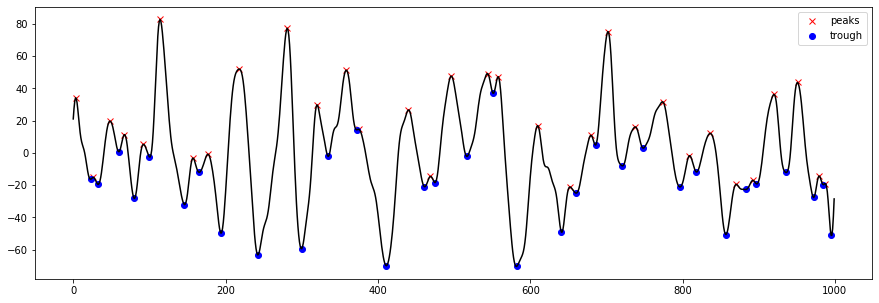

No valid trough


In [156]:
df = waveform_analyzer.analyze_waveform(raw.get_data()[5,:1000], peak_dist=1, trough_dist=5, 
                        label=False, y_contra=raw.get_data()[9,:], y_ipsi=raw.get_data()[8,:], plot_=True)

In [155]:
df

,MOV_TYPE,decay_steepness,decay_time,interval,label,peak_idx_left,peak_idx_right,peak_left,peak_right,prominence,rise_steepness,rise_time,sharpness,slope_ratio,trough,trough_idx,width,y_contra,y_ipsi
0,None,0.467732,-20.0,0.0,0.0,3.0,26.0,34.163946,-15.254451,25.820966,-0.107464,3.0,-12.207560,-0.575195,-16.366218,23.0,23.0,None,None
1,None,4.113233,-7.0,10.0,0.0,26.0,48.0,-15.254451,19.718646,21.800531,-0.053774,15.0,-12.374388,-4.167006,-19.568434,33.0,22.0,None,None
2,None,2.207595,-12.0,27.0,0.0,48.0,67.0,19.718646,11.330557,14.822179,-0.133690,7.0,8.843178,-2.341285,0.702423,60.0,19.0,None,None
3,None,4.730218,-13.0,20.0,0.0,67.0,92.0,11.330557,5.291756,36.578935,-0.212527,12.0,-14.440563,-4.942745,-28.267779,80.0,25.0,None,None
4,None,10.941444,-8.0,20.0,0.0,92.0,114.0,5.291756,82.836570,46.585803,-0.171056,14.0,8.433079,-11.112500,-2.521640,100.0,22.0,None,None
5,None,4.278221,-32.0,46.0,0.0,114.0,157.0,82.836570,-3.225964,71.884045,-0.590847,11.0,-22.714395,-4.869067,-32.078742,146.0,43.0,None,None
6,None,1.496080,-8.0,19.0,0.0,157.0,177.0,-3.225964,-0.828952,9.996523,-0.221568,12.0,-7.326382,-1.717648,-12.023980,165.0,20.0,None,None
7,None,7.897489,-17.0,29.0,0.0,177.0,218.0,-0.828952,51.993789,75.440061,-0.422928,24.0,-33.177057,-8.320417,-49.857642,194.0,41.0,None,None
8,None,7.065936,-24.0,48.0,0.0,218.0,281.0,51.993789,77.294390,127.894234,-0.219503,39.0,-49.331765,-7.285439,-63.250145,242.0,63.0,None,None
9,None,7.857335,-19.0,58.0,0.0,281.0,320.0,77.294390,29.810181,113.005562,-0.073879,20.0,-45.759652,-7.931214,-59.453277,300.0,39.0,None,None
